In [ ]:
import os

os.environ["EQX_ON_ERROR"] = "nan"
import sys

import healpy as hp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax_healpy import combine_masks, from_cutout_to_fullmap, get_clusters, get_cutout_from_mask
from matplotlib.patches import Patch

sys.path.append("../data")
from generate_maps import get_mask

out_folder = "plots"
os.makedirs(out_folder, exist_ok=True)

<Figure size 1000x500 with 0 Axes>

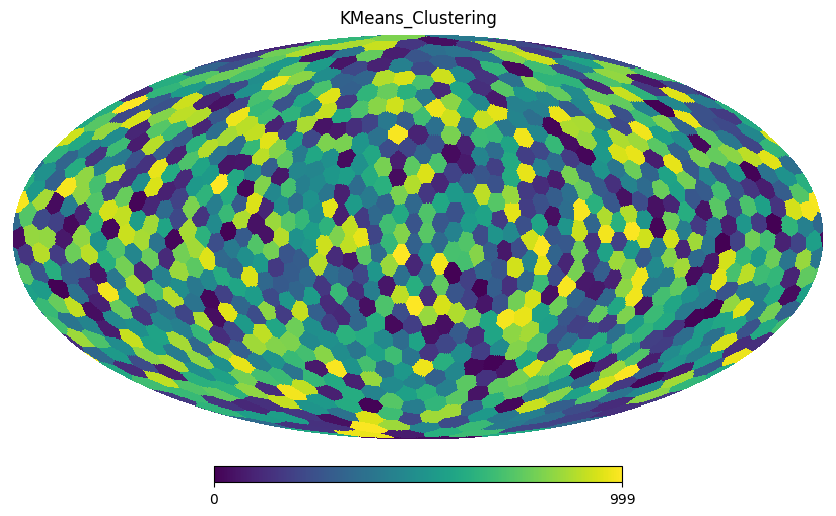

In [ ]:
nside = 256
npixels = hp.nside2npix(nside)

mask = jnp.ones(npixels)
(indices,) = jnp.where(mask == 1)

full_map = get_clusters(mask, indices, 1000, jax.random.PRNGKey(0), max_centroids=1000)

# Set up subplots
fig = plt.figure(figsize=(10, 5))
# Plot each map
hp.mollview(full_map, title="KMeans_Clustering", bgcolor=(0.0,) * 4)
# Display the plot
plt.savefig(f"{out_folder}/kmeans_clustering.pdf", dpi=1200, bbox_inches="tight", transparent=True)
plt.show()

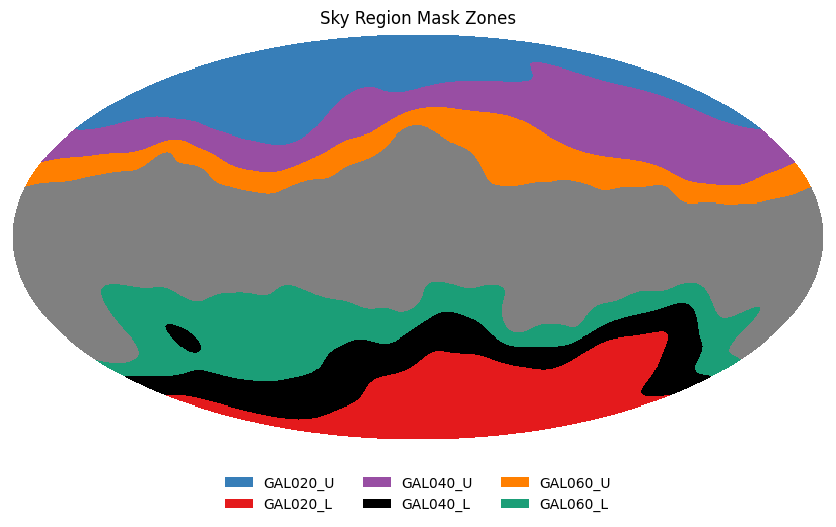

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load binary masks
gal020_u = get_mask("GAL020_U", nside=2048)
gal020_l = get_mask("GAL020_L", nside=2048)
gal040_u = get_mask("GAL040_U", nside=2048)
gal040_l = get_mask("GAL040_L", nside=2048)
gal060_u = get_mask("GAL060_U", nside=2048)
gal060_l = get_mask("GAL060_L", nside=2048)

# Combine into a single labeled mask
full_mask = gal020_u * 1 + gal020_l * 2 + gal040_u * 3 + gal040_l * 4 + gal060_u * 5 + gal060_l * 6
full_mask = full_mask.astype(np.float64)
# Set 0s (unmasked regions) to hp.UNSEEN to hide them
full_mask[full_mask == 0] = hp.UNSEEN

# Define labels and values
labels = ["GAL020_U", "GAL020_L", "GAL040_U", "GAL040_L", "GAL060_U", "GAL060_L"]
values = [1, 2, 3, 4, 5, 6]

# Define distinct colors (you can tweak these if needed)
distinct_colors = [
    "#377eb8",  # blue
    "#e41a1c",  # red
    "#984ea3",  # purple
    "#000000",  # dark gray (replaces green)
    "#ff7f00",  # orange
    "#1b9e77",  # teal (distant from blue)
]

# Create colormap for values 1-6 (index 0 is ignored)
cmap = ListedColormap(["black"] + distinct_colors)

# Plot with custom colormap and colorbar off
hp.mollview(
    full_mask,
    title="Sky Region Mask Zones",
    cbar=False,
    cmap=cmap,
    min=0,
    max=6,
    bgcolor=(0.0,) * 4,
)

# Create legend patches
legend_elements = [
    Patch(facecolor=color, label=label) for label, color in zip(labels, distinct_colors)
]

# Add legend below map
plt.legend(
    handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False
)

# Save and show
plt.savefig(
    f"{out_folder}/sky_region_mask_zones.pdf", dpi=600, bbox_inches="tight", transparent=True
)
plt.show()

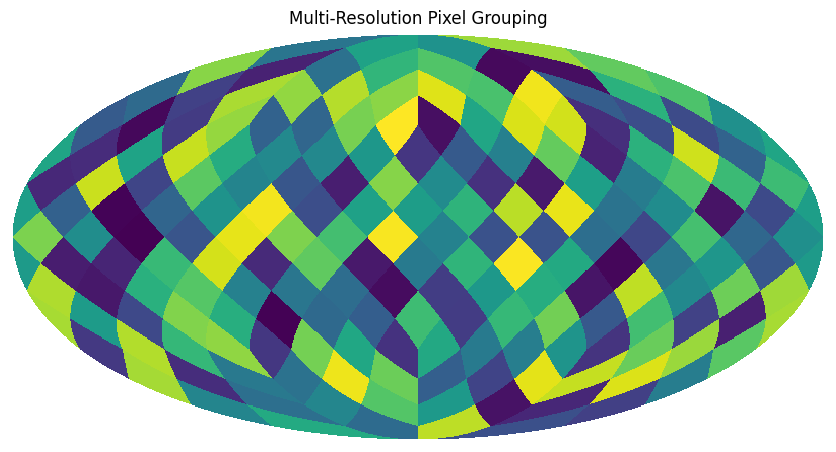

In [ ]:
# Load binary masks
np.random.seed(0)

nside = 64
npixels = hp.nside2npix(nside)
gal020 = np.ones(npixels)
npix = nside**2 * 12
ipix = np.arange(npix)


def ud_grade(ipix, nside_in, nside_out):
    if nside_out == 0:
        return np.zeros_like(ipix)
    else:
        lowered = hp.ud_grade(ipix, nside_out=nside_out)
        return hp.ud_grade(lowered, nside_out=nside_in)


ud_beta_d_map = ud_grade(ipix, nside, 4).astype(np.float64)

(indices,) = np.where(gal020 == 0)


def normalize_array(arr):
    unique_vals, indices = np.unique(arr, return_inverse=True)
    return indices.astype(np.float64)


def shuffle_labels(arr):
    unique_vals = np.unique(arr[arr != hp.UNSEEN])  # Ignore UNSEEN
    shuffled_vals = np.random.permutation(unique_vals)

    # Create mapping dict
    mapping = dict(zip(unique_vals, shuffled_vals))

    # Vectorized mapping
    shuffled_arr = np.vectorize(lambda x: mapping.get(x, hp.UNSEEN))(arr)
    return shuffled_arr.astype(np.float64)


ud_beta_d_map = normalize_array(ud_beta_d_map)
ud_beta_d_map[indices] = hp.UNSEEN

ud_beta_d_map = shuffle_labels(ud_beta_d_map)

hp.mollview(
    ud_beta_d_map,
    title="Multi-Resolution Pixel Grouping",
    # cmap="cividis",  # or "cubehelix", "YlGnBu", "Greys", etc.
    cbar=False,
)
plt.savefig(
    f"{out_folder}/multi_resolution_pixel_grouping.pdf",
    dpi=600,
    bbox_inches="tight",
    transparent=True,
)

In [ ]:
np.random.seed(0)

indices_list = []
maps_list = []
masks = []

nside = 256
npix = nside**2 * 12
ipix = np.arange(npix)

ud_grades = [(64, 0, 2), (64, 4, 2), (64, 8, 4), (64, 8, 4), (64, 4, 2), (64, 0, 2)]

ud_grades = jax.tree.map(lambda x: int(x * nside / 64), ud_grades)
previous_mask_size = {
    "beta_dust_patches": 0,
    "temp_dust_patches": 0,
    "beta_pl_patches": 0,
}
for udgrade, mask_name in zip(
    ud_grades, ["GAL020_U", "GAL040_U", "GAL060_U", "GAL060_L", "GAL040_L", "GAL020_L"]
):
    mask = get_mask(mask_name, nside=nside)
    (indices,) = jnp.where(mask == 1)

    def ud_grade(ipix, nside_in, nside_out):
        if nside_out == 0:
            return np.zeros_like(ipix)
        else:
            lowered = hp.ud_grade(ipix, nside_out=nside_out)
            return hp.ud_grade(lowered, nside_out=nside_in)

    ud_beta_d_map = ud_grade(ipix, nside, udgrade[0])
    ud_temp_d_map = ud_grade(ipix, nside, udgrade[1])
    ud_beta_pl_map = ud_grade(ipix, nside, udgrade[2])

    # These downgraded maps serve as our patch indices.
    patch_indices = {
        "beta_dust_patches": ud_beta_d_map,
        "temp_dust_patches": ud_temp_d_map,
        "beta_pl_patches": ud_beta_pl_map,
    }
    patch_indices = get_cutout_from_mask(patch_indices, indices)

    def normalize_array(arr):
        unique_vals, indices = np.unique(arr, return_inverse=True)
        return indices

    patch_indices = jax.tree.map(normalize_array, patch_indices)
    patch_indices = jax.tree.map(lambda x, p: x + p, patch_indices, previous_mask_size)
    previous_mask_size = jax.tree.map(
        lambda x, p: p + np.unique(x).size, patch_indices, previous_mask_size
    )

    indices_list.append(indices)
    maps_list.append(patch_indices)
    masks.append(mask)


def normalize_array(arr):
    unique_vals, indices = np.unique(arr, return_inverse=True)
    return indices


full_mask = np.logical_or.reduce(masks, axis=0)
(full_indices,) = jnp.where(full_mask == 1)

full_map = combine_masks(maps_list, indices_list, nside)
full_map = get_cutout_from_mask(full_map, full_indices)
full_map = jax.tree.map(normalize_array, full_map)
full_map = from_cutout_to_fullmap(full_map, full_indices, nside)

min_val = 0


def shuffle_labels(arr):
    unique_vals = np.unique(arr[arr != hp.UNSEEN])  # Ignore UNSEEN
    shuffled_vals = np.random.permutation(unique_vals)

    # Create mapping dict
    mapping = dict(zip(unique_vals, shuffled_vals))

    # Vectorized mapping
    shuffled_arr = np.vectorize(lambda x: mapping.get(x, hp.UNSEEN))(arr)
    return shuffled_arr.astype(np.float64)


full_map = jax.tree.map(shuffle_labels, full_map)


figure = plt.figure(figsize=(4, 7))

hp.mollview(
    full_map["beta_dust_patches"],
    title=r"$\beta_d$",
    min=min_val,
    max=np.max(full_map["beta_dust_patches"]),
    cbar=True,
    sub=(3, 1, 1),
    bgcolor=(0, 0, 0, 0),  # Transparent background
)
hp.mollview(
    full_map["temp_dust_patches"],
    title=r"$T_d$",
    min=min_val,
    max=np.max(full_map["temp_dust_patches"]),
    cbar=True,
    sub=(3, 1, 2),
    bgcolor=(0, 0, 0, 0),
)
hp.mollview(
    full_map["beta_pl_patches"],
    title=r"$\beta_s$",
    min=min_val,
    max=np.max(full_map["beta_pl_patches"]),
    cbar=True,
    sub=(3, 1, 3),
    bgcolor=(0, 0, 0, 0),
)
plt.plot()

In [ ]:
nside = 256
npixels = hp.nside2npix(nside)

np.random.seed(0)

GAL020_U = get_mask("GAL020_U")
(indices,) = jnp.where(GAL020_U == 1)

GAL020_U_patch_count = {
    "temp_dust_patches": 5,
    "beta_dust_patches": 2000,
    "beta_pl_patches": 20,
}
GAL020_L_patch_count = {
    "temp_dust_patches": 15,
    "beta_dust_patches": 2000,
    "beta_pl_patches": 25,
}
GAL040_U_patch_count = {
    "temp_dust_patches": 5,
    "beta_dust_patches": 3000,
    "beta_pl_patches": 20,
}
GAL040_L_patch_count = {
    "temp_dust_patches": 10,
    "beta_dust_patches": 3000,
    "beta_pl_patches": 5,
}
GAL060_U_patch_count = {
    "temp_dust_patches": 5,
    "beta_dust_patches": 4000,
    "beta_pl_patches": 5,
}
GAL060_L_patch_count = {
    "temp_dust_patches": 10,
    "beta_dust_patches": 4000,
    "beta_pl_patches": 10,
}

patch_count_list = [
    GAL020_U_patch_count,
    GAL040_U_patch_count,
    GAL060_U_patch_count,
    GAL060_L_patch_count,
    GAL040_L_patch_count,
    GAL020_L_patch_count,
]

indices_list = []
maps_list = []
masks = []

previous_mask_size = {
    "beta_dust_patches": 0,
    "temp_dust_patches": 0,
    "beta_pl_patches": 0,
}

for patch_count, mask_name in zip(
    patch_count_list, ["GAL020_U", "GAL040_U", "GAL060_U", "GAL060_L", "GAL040_L", "GAL020_L"]
):
    mask = get_mask(mask_name, nside)
    (indices,) = jnp.where(mask == 1)

    full_map = jax.tree.map(
        lambda x: get_clusters(
            mask, indices, x, jax.random.key(0), max_centroids=4000, initial_sample_size=1
        ),
        patch_count,
    )
    full_map = get_cutout_from_mask(full_map, indices)

    full_map = jax.tree.map(lambda x, p: x + p, full_map, previous_mask_size)
    previous_mask_size = jax.tree.map(
        lambda x, p: p + np.unique(x).size, full_map, previous_mask_size
    )

    maps_list.append(full_map)
    indices_list.append(indices)
    masks.append(mask)

full_full_map = combine_masks(maps_list, indices_list, nside)


def shuffle_labels(arr):
    unique_vals = np.unique(arr[arr != hp.UNSEEN])  # Ignore UNSEEN
    shuffled_vals = np.random.permutation(unique_vals)

    # Create mapping dict
    mapping = dict(zip(unique_vals, shuffled_vals))

    # Vectorized mapping
    shuffled_arr = np.vectorize(lambda x: mapping.get(x, hp.UNSEEN))(arr)
    return shuffled_arr.astype(np.float64)


full_full_map = jax.tree.map(shuffle_labels, full_full_map)

min_val = 0

figure = plt.figure(figsize=(4, 7))

hp.mollview(
    full_full_map["beta_dust_patches"],
    title=r"$\beta_d$",
    min=min_val,
    max=np.max(full_full_map["beta_dust_patches"]),
    cbar=True,
    sub=(3, 1, 1),
    bgcolor=(0, 0, 0, 0),  # Transparent background
)
hp.mollview(
    full_full_map["temp_dust_patches"],
    title=r"$T_d$",
    min=min_val,
    max=np.max(full_full_map["temp_dust_patches"]),
    cbar=True,
    sub=(3, 1, 2),
    bgcolor=(0, 0, 0, 0),
)
hp.mollview(
    full_full_map["beta_pl_patches"],
    title=r"$\beta_s$",
    min=min_val,
    max=np.max(full_full_map["beta_pl_patches"]),
    cbar=True,
    sub=(3, 1, 3),
    bgcolor=(0, 0, 0, 0),
)
plt.plot()